In [ ]:
    import numpy as np
    import pandas as pd
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    import pickle
    import matplotlib.pyplot as plt
    import time

    # Dense layer
    class Layer_Dense:
        def __init__(self, n_inputs, n_neurons, weight_init_func):
            self.weights, self.biases = self.initialize_weights_and_biases(n_inputs, n_neurons, weight_init_func)
        
        def initialize_weights_and_biases(self, n_inputs, n_neurons, weight_init_func):
            return weight_init_func(n_inputs, n_neurons)
        
        def forward(self, inputs):
            self.inputs = inputs
            self.output = self.calculate_output(inputs, self.weights, self.biases)
        
        def calculate_output(self, inputs, weights, biases):
            return self.dot_product(inputs, weights) + biases
        
        def dot_product(self, inputs, weights):
            return np.dot(inputs, weights)
        
        def backward(self, dvalues):
            self.dweights = self.calculate_dweights(dvalues)
            self.dbiases = self.calculate_dbiases(dvalues)
            self.dinputs = self.calculate_dinputs(dvalues)
        
        def calculate_dweights(self, dvalues):
            return self.dot_product(self.inputs.T, dvalues)
        
        def calculate_dbiases(self, dvalues):
            return np.sum(dvalues, axis=0, keepdims=True)
        
        def calculate_dinputs(self, dvalues):
            return self.dot_product(dvalues, self.weights.T)

    # Weight initialization functions
    def zero_init(n_inputs, n_neurons):
        weights = np.zeros((n_inputs, n_neurons))
        biases = np.zeros((1, n_neurons))
        return weights, biases

    def random_init(n_inputs, n_neurons):
        weights = 0.01 * np.random.rand(n_inputs, n_neurons)
        biases = 0.01 * np.random.rand(1, n_neurons)
        return weights, biases

    def normal_init(n_inputs, n_neurons):
        weights = np.random.randn(n_inputs, n_neurons) * np.sqrt(2 / n_inputs)
        biases = np.zeros((1, n_neurons))
        return weights, biases
    # ReLU Activation
    class Activation_ReLU:
        def forward(self, inputs):
            self.inputs = inputs
            self.output = self.apply_relu(inputs)
        
        def apply_relu(self, inputs):
            return np.maximum(0, inputs)
        
        def backward(self, dvalues):
            self.dinputs = self.calculate_backward_relu(dvalues)
        
        def calculate_backward_relu(self, dvalues):
            dinputs = dvalues.copy()
            dinputs[self.inputs <= 0] = 0
            return dinputs

    # Sigmoid Activation
    class Activation_Sigmoid:
        def forward(self, inputs):
            self.inputs = inputs
            self.output = self.apply_sigmoid(inputs)
        
        def apply_sigmoid(self, inputs):
            return 1 / (1 + np.exp(-inputs))
        
        def backward(self, dvalues):
            self.dinputs = self.calculate_backward_sigmoid(dvalues)
        
        def calculate_backward_sigmoid(self, dvalues):
            return dvalues * (self.output * (1 - self.output))

    # Tanh Activation
    class Activation_Tanh:
        def forward(self, inputs):
            self.inputs = inputs
            self.output = self.apply_tanh(inputs)
        
        def apply_tanh(self, inputs):
            return np.tanh(inputs)
        
        def backward(self, dvalues):
            self.dinputs = self.calculate_backward_tanh(dvalues)
        
        def calculate_backward_tanh(self, dvalues):
            return dvalues * (1 - self.output ** 2)

    # Leaky ReLU Activation
    class Activation_LeakyReLU:
        def forward(self, inputs):
            self.inputs = inputs
            self.output = self.apply_leaky_relu(inputs)
        
        def apply_leaky_relu(self, inputs):
            return np.where(inputs > 0, inputs, 0.01 * inputs)
        
        def backward(self, dvalues):
            self.dinputs = self.calculate_backward_leaky_relu(dvalues)
        
        def calculate_backward_leaky_relu(self, dvalues):
            dinputs = dvalues.copy()
            dinputs[self.inputs < 0] *= 0.01
            return dinputs

    # Softmax Activation
    class Activation_Softmax:
        def forward(self, inputs):
            self.output = self.apply_softmax(inputs)
        
        def apply_softmax(self, inputs):
            exp_values = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
            return exp_values / np.sum(exp_values, axis=1, keepdims=True)
        
        def backward(self, dvalues):
            self.dinputs = self.calculate_backward_softmax(dvalues)
        
        def calculate_backward_softmax(self, dvalues):
            dinputs = np.empty_like(dvalues)
            for index, (single_output, single_dvalues) in enumerate(zip(self.output, dvalues)):
                dinputs[index] = self.softmax_jacobian_dot(single_output, single_dvalues)
            return dinputs
        
        def softmax_jacobian_dot(self, single_output, single_dvalues):
            single_output = single_output.reshape(-1, 1)
            jacobian_matrix = self.calculate_softmax_jacobian(single_output)
            return np.dot(jacobian_matrix, single_dvalues)
        
        def calculate_softmax_jacobian(self, single_output):
            return np.diagflat(single_output) - np.dot(single_output, single_output.T)

    class Activation_Softmax:
        def forward(self, inputs):
            self.output = self.apply_softmax(inputs)
        
        def apply_softmax(self, inputs):
            exp_values = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
            return exp_values / np.sum(exp_values, axis=1, keepdims=True)
        
        def backward(self, dvalues):
            self.dinputs = self.calculate_backward_softmax(dvalues)
        
        def calculate_backward_softmax(self, dvalues):
            dinputs = np.empty_like(dvalues)
            for index, (single_output, single_dvalues) in enumerate(zip(self.output, dvalues)):
                dinputs[index] = self.softmax_jacobian_dot(single_output, single_dvalues)
            return dinputs
        
        def softmax_jacobian_dot(self, single_output, single_dvalues):
            single_output = single_output.reshape(-1, 1)
            jacobian_matrix = self.calculate_softmax_jacobian(single_output)
            return np.dot(jacobian_matrix, single_dvalues)
        
        def calculate_softmax_jacobian(self, single_output):
            return np.diagflat(single_output) - np.dot(single_output, single_output.T)

    # Loss function
    class Loss_CategoricalCrossentropy:
        def forward(self, y_pred, y_true):
            samples = len(y_pred)
            y_pred_clipped = self.clip_predictions(y_pred)
            correct_confidences = self.get_correct_confidences(y_pred_clipped, y_true, samples)
            return self.calculate_loss(correct_confidences)
        
        def clip_predictions(self, y_pred):
            return np.clip(y_pred, 1e-7, 1 - 1e-7)
        
        def get_correct_confidences(self, y_pred_clipped, y_true, samples):
            if len(y_true.shape) == 1:
                if np.max(y_true) >= y_pred_clipped.shape[1]:
                    raise IndexError(f"y_true contains values that are out of bounds. Max y_true value: {np.max(y_true)}, number of classes: {y_pred_clipped.shape[1]}")
                return y_pred_clipped[range(samples), y_true]
            elif len(y_true.shape) == 2:
                return np.sum(y_pred_clipped * y_true, axis=1)
        
        def calculate_loss(self, correct_confidences):
            return -np.log(correct_confidences)

        def backward(self, dvalues, y_true):
            samples = len(dvalues)
            labels = len(dvalues[0])
            y_true_one_hot = self.convert_to_one_hot(y_true, labels)
            self.dinputs = self.calculate_dinputs(y_true_one_hot, dvalues, samples)
        
        def convert_to_one_hot(self, y_true, labels):
            if len(y_true.shape) == 1:
                return np.eye(labels)[y_true]
            return y_true
        
        def calculate_dinputs(self, y_true_one_hot, dvalues, samples):
            dinputs = -y_true_one_hot / dvalues
            return dinputs / samples
        
        def calculate(self, y_pred, y_true):
            sample_losses = self.forward(y_pred, y_true)
            return self.calculate_mean_loss(sample_losses)
        
        def calculate_mean_loss(self, sample_losses):
            return np.mean(sample_losses)

    # Combined Softmax activation and categorical cross-entropy loss
    class Activation_Softmax_Loss_CategoricalCrossentropy:
        def __init__(self):
            self.activation = Activation_Softmax()
            self.loss = Loss_CategoricalCrossentropy()

        def forward(self, inputs, y_true):
            self.output = self.perform_activation(inputs)
            return self.calculate_loss(self.output, y_true)
        
        def perform_activation(self, inputs):
            self.activation.forward(inputs)
            return self.activation.output
        
        def calculate_loss(self, predictions, y_true):
            return np.mean(self.loss.forward(predictions, y_true))
        
        def backward(self, y_true):
            samples = len(self.output)
            y_true = self.convert_to_class_indices(y_true)
            self.dinputs = self.calculate_dinputs(self.output, y_true, samples)
        
        def convert_to_class_indices(self, y_true):
            if len(y_true.shape) == 2:
                return np.argmax(y_true, axis=1)
            return y_true
        
        def calculate_dinputs(self, predictions, y_true, samples):
            dinputs = predictions.copy()
            dinputs[range(samples), y_true] -= 1
            return dinputs / samples
        
    # Neural Network class
    class NeuralNetwork:
        def __init__(self, N, neurons, lr, activation_func, weight_init_func, epochs, batch_size):
            self.N = N
            self.neurons = neurons
            self.lr = lr
            self.activation_func = activation_func
            self.weight_init_func = weight_init_func
            self.epochs = epochs
            self.batch_size = batch_size

            # Initialize layers and activations separately
            self.layers = []
            self.activations = []
            for i in range(N - 1):
                self.layers.append(Layer_Dense(neurons[i], neurons[i + 1], weight_init_func))
                self.activations.append(activation_func())
            self.loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()

        def fit(self, X, Y):
            for epoch in range(self.epochs):
                for i in range(0, len(X), self.batch_size):
                    X_batch = X[i:i + self.batch_size]
                    Y_batch = Y[i:i + self.batch_size]

                    # Forward pass
                    output = X_batch
                    for layer, activation in zip(self.layers, self.activations):
                        layer.forward(output)
                        activation.forward(layer.output)
                        output = activation.output

                    # Loss calculation and backward pass
                    loss = self.loss_activation.forward(output, Y_batch)
                    self.loss_activation.backward(Y_batch)

                    dvalues = self.loss_activation.dinputs
                    for layer, activation in reversed(list(zip(self.layers, self.activations))):
                        activation.backward(dvalues)
                        dvalues = activation.dinputs
                        layer.backward(dvalues)
                        dvalues = layer.dinputs

                    # Update weights
                    for layer in self.layers:
                        layer.weights -= self.lr * layer.dweights
                        layer.biases -= self.lr * layer.dbiases

                print(f'Epoch {epoch + 1}/{self.epochs} - Loss: {loss}')

        def predict(self, X):
            output = X
            for layer, activation in zip(self.layers, self.activations):
                layer.forward(output)
                activation.forward(layer.output)
                output = activation.output
            self.loss_activation.activation.forward(output)
            return np.argmax(self.loss_activation.activation.output, axis=1)

        def predict_proba(self, X):
            output = X
            for layer, activation in zip(self.layers, self.activations):
                layer.forward(output)
                activation.forward(layer.output)
                output = activation.output
            self.loss_activation.activation.forward(output)
            return self.loss_activation.activation.output

        def score(self, X, Y):
            predictions = self.predict(X)
            if len(Y.shape) == 2:
                Y = np.argmax(Y, axis=1)
            return np.mean(predictions == Y)


In [ ]:
data = pd.read_csv('fashion-mnist_train.csv').iloc[:300]  

X = data.iloc[:, 1:].values
Y = data.iloc[:, 0].values

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.2, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)



Training with Activation_ReLU and zero_init
Epoch 1/100 - Loss: 3.4657359027997265
Epoch 2/100 - Loss: 3.4657359027997265
Epoch 3/100 - Loss: 3.4657359027997265
Epoch 4/100 - Loss: 3.4657359027997265
Epoch 5/100 - Loss: 3.4657359027997265
Epoch 6/100 - Loss: 3.4657359027997265
Epoch 7/100 - Loss: 3.4657359027997265
Epoch 8/100 - Loss: 3.4657359027997265
Epoch 9/100 - Loss: 3.4657359027997265
Epoch 10/100 - Loss: 3.4657359027997265
Epoch 11/100 - Loss: 3.4657359027997265
Epoch 12/100 - Loss: 3.4657359027997265
Epoch 13/100 - Loss: 3.4657359027997265
Epoch 14/100 - Loss: 3.4657359027997265
Epoch 15/100 - Loss: 3.4657359027997265
Epoch 16/100 - Loss: 3.4657359027997265
Epoch 17/100 - Loss: 3.4657359027997265
Epoch 18/100 - Loss: 3.4657359027997265
Epoch 19/100 - Loss: 3.4657359027997265
Epoch 20/100 - Loss: 3.4657359027997265
Epoch 21/100 - Loss: 3.4657359027997265
Epoch 22/100 - Loss: 3.4657359027997265
Epoch 23/100 - Loss: 3.4657359027997265
Epoch 24/100 - Loss: 3.4657359027997265
Epoc

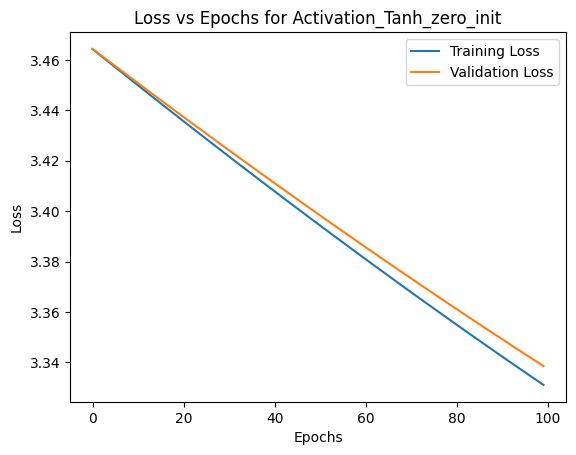

In [ ]:
layer_sizes = [256, 128, 64, 32]
epochs = 10 
batch_size = 128
learning_rate = 1e-4  

activation_functions = [Activation_ReLU, Activation_Sigmoid, Activation_Tanh, Activation_LeakyReLU]
weight_initializations = [zero_init, random_init, normal_init]

training_losses = {}
validation_losses = {}

for activation_func in activation_functions:
    for weight_init_func in weight_initializations:
        print(f"\nTraining with {activation_func.__name__} and {weight_init_func.__name__}")

        model = NeuralNetwork(
            N=len(layer_sizes) + 1,
            neurons=[X_train.shape[1]] + layer_sizes + [10],  
            lr=learning_rate,
            activation_func=activation_func,
            weight_init_func=weight_init_func,
            epochs=epochs,
            batch_size=batch_size
        )

        train_loss_per_epoch = []
        val_loss_per_epoch = []

        for epoch in range(epochs):
            start_time = time.time()

            model.fit(X_train, Y_train)

            train_loss = model.loss_activation.loss.calculate(model.predict_proba(X_train), Y_train)
            val_loss = model.loss_activation.loss.calculate(model.predict_proba(X_val), Y_val)
            train_loss_per_epoch.append(train_loss)
            val_loss_per_epoch.append(val_loss)

            end_time = time.time()
            print(f"Epoch {epoch + 1}, Train Loss: {train_loss}, Validation Loss: {val_loss}, Time: {end_time - start_time:.2f} seconds")

            if epoch > 2 and val_loss >= val_loss_per_epoch[-2]:
                print("Early stopping due to no improvement in validation loss.")
                break

        key = f"{activation_func.__name__}_{weight_init_func.__name__}"
        training_losses[key] = train_loss_per_epoch
        validation_losses[key] = val_loss_per_epoch

        with open(f"model_{key}.pkl", "wb") as f:
            pickle.dump(model, f)



for key in training_losses.keys():
    plt.figure()
    plt.plot(training_losses[key], label="Training Loss")
    plt.plot(validation_losses[key], label="Validation Loss")
    plt.title(f"Loss vs Epochs for {key}")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


In [ ]:
import pickle
def eval_function(data):
    print(f"Evaluating data: {data}")

def load_pickle_file(file_path):
    try:
        with open(file_path, 'rb') as file:
            data = pickle.load(file)
            print(f"Successfully loaded data from {file_path}")
            return data
    except Exception as e:
        print(f"Error loading pickle file {file_path}: {e}")
        return None

pickle_files = ["/home/amw/Sem 5/ML/ML_Assignment3_2022091/B part/model_Activation_LeakyReLU_normal_init.pkl"]

for file_path in pickle_files:
    data = load_pickle_file(file_path)
    if data is not None:
        eval_function(data)


Error loading pickle file /home/amw/Sem 5/ML/ML_Assignment3_2022091/B part/model_Activation_LeakyReLU_normal_init.pkl: Can't get attribute 'NeuralNetwork' on <module '__main__'>
